<IPython.core.display.Javascript object>


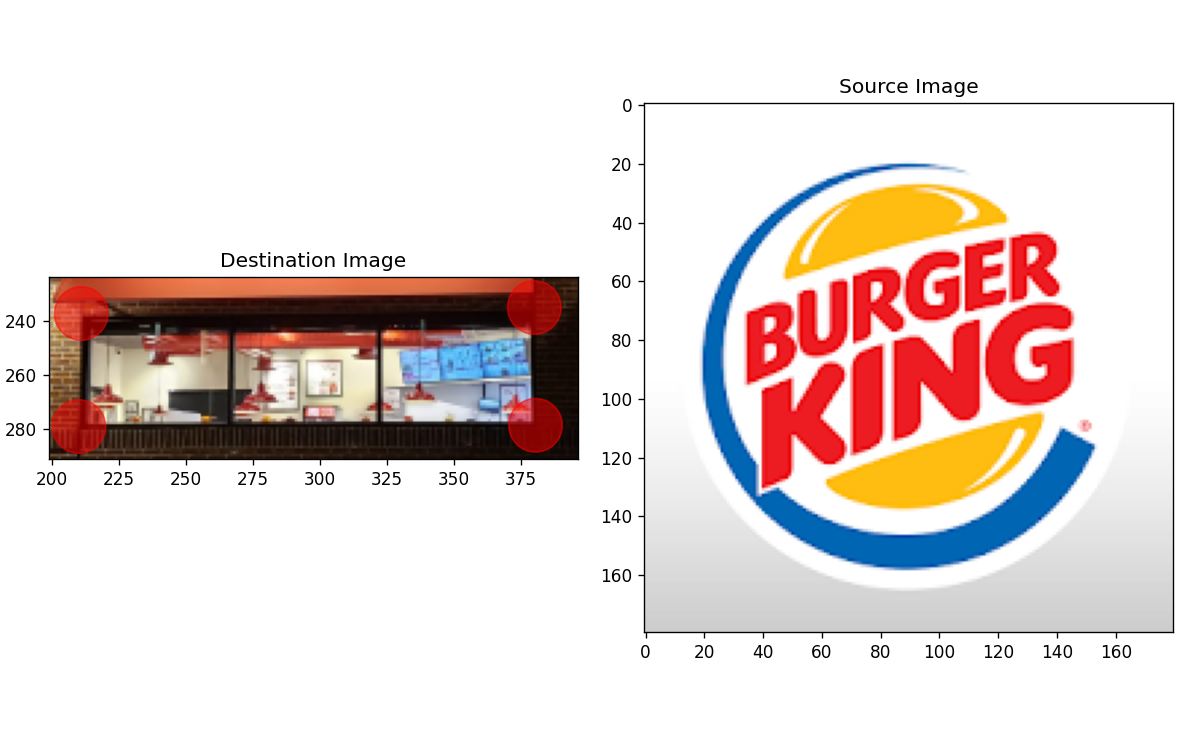

<IPython.core.display.Javascript object>

In [7]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

import IPython.display
import ipywidgets as widgets  # Using the ipython notebook widgets


#Use 'jpeg' instead of 'png' (~5 times faster)
import PIL.Image
from io import BytesIO

#Use 'jpeg' instead of 'png' (~5 times faster)
def imdisplay(img, fmt='jpeg',width=500):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_p = PIL.Image.fromarray(img)    
    f = BytesIO()
    if new_p.mode != 'RGB':
        new_p = new_p.convert('RGB')
    new_p.save(f, fmt)
    return IPython.display.Image(data=f.getvalue(), width=width)


from IPython.display import Javascript
def preventScrolling():
    disable_js = """
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    """
    display(Javascript(disable_js))


def imwidget(img, fmt='jpeg',width=500):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Create binary stream object
    f = BytesIO()
    #Convert array to binary stream object
    new_p = PIL.Image.fromarray(img)
    if new_p.mode != 'RGB':
        new_p = new_p.convert('RGB')
    new_p.save(f, fmt)
    return widgets.Image(value=f.getvalue(), format=fmt, width=width)

def implot(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
import urllib
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

def createHTMLList(data):
    final = f'''<ul style="list-style-type:none;">'''
    for x, y in data:
        final += f'''<li>({str(int(x))}, {str(int(y))})</li>'''
    final += "</ul>"
    return final
    

    
def enter_axes(event):
    global current_axis
    current_axis = event.inaxes

def leave_axes(event):
    global current_axis
    current_axis = None
    
def enter_figure(event):
    event.canvas.figure.patch.set_facecolor('grey')
    event.canvas.draw()

def leave_figure(event):
    event.canvas.figure.patch.set_facecolor('white')
    event.canvas.draw()
    

def setSourceDim(event):
    global src_pts
    src_pts = [[0,0],[src_img.shape[0], 0], [src_img.shape[0], src_img.shape[1]], [0, src_img.shape[1]]]
    src_txt.value = createHTMLList(src_pts)
    if (len(src_pts) == 4 and len(dest_pts) == 4):
        confirm_btn.disabled = False
        if (autorun.value):
                    replacePlanes(src_pts, dest_pts)
    else:
        confirm_btn.disabled = True

def resetSrc(event):
    global img_src
    try:
        img_src.patches = []
    except:
        pass
    finally:
        src_pts.clear()
        src_txt.value = createHTMLList(src_pts)
    
def resetDest(event):
    global img_dest
    try:
        img_dest.patches = []
    except:
        pass
    finally:
        dest_pts.clear()
        dest_txt.value = createHTMLList(dest_pts)

def popDest(event):
    global img_dest
    try:
        dest_pts.pop()
        img_dest.patches[-1].remove()
    except:
        pass
    
    dest_txt.value = createHTMLList(dest_pts)
    
def onclick(event):
    global current_axis
    if (current_axis == img_src and len(src_pts) < 4):
        src_pts.append([np.round(event.xdata), np.round(event.ydata)])
        src_txt.value = createHTMLList(src_pts)
        circle = plt.Circle((event.xdata, event.ydata), radius=2, color='r', alpha=0.5)
        current_axis.add_patch(circle)
        current_axis.figure.canvas.draw()
        
    elif (current_axis== img_dest and len(dest_pts) < 4):
        dest_pts.append(np.array([np.round(event.xdata), np.round(event.ydata)]))
        dest_txt.value = createHTMLList(dest_pts)
        circle = plt.Circle((event.xdata, event.ydata), radius=10, color='r', alpha=0.5)
        current_axis.add_patch(circle)
        current_axis.figure.canvas.draw()
        
    if (len(src_pts) == 4 and len(dest_pts) == 4):
        confirm_btn.disabled = False
        if (autorun.value):
            replacePlanes(src_pts, dest_pts)

    else:
        confirm_btn.disabled = True

    
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def runReplacePlanes(event):
    replacePlanes(src_pts, dest_pts)

def setupUI(fig):
    fig.canvas.mpl_connect('axes_enter_event', enter_axes)
    fig.canvas.mpl_connect('axes_leave_event', leave_axes)
    fig.canvas.mpl_connect('figure_enter_event', enter_figure)
    fig.canvas.mpl_connect('figure_leave_event', leave_figure)
    fig.canvas.mpl_connect('button_press_event', onclick)
    src_dim_btn.on_click(setSourceDim)
    reset_src_btn.on_click(resetSrc)
    reset_dest_btn.on_click(resetDest)
    pop_dest_btn.on_click(popDest)
    confirm_btn.on_click(runReplacePlanes)
    
    preventScrolling()

def replacePlanes(src_pts, dest_pts):
    global src_img, dest_img
    # Alternate if only 4 points
    src_pts_ordered = order_points(np.array(src_pts))
    dest_pts_ordered = order_points(np.array(dest_pts))
    # H=cv2.getPerspectiveTransform(src_pts, dest_pts)
    H,mask = cv2.findHomography(src_pts_ordered, dest_pts_ordered, cv2.RANSAC,5.0)

    # Warp source image to destination based on homography
    # size argument is width x height, so have to reverse shape values 
    src_warped = cv2.warpPerspective(src_img, H, (dest_img.shape[1],dest_img.shape[0]))

    dest_img = cv2.fillConvexPoly(np.array(dest_img, 'int32'),np.array(dest_pts_ordered, 'int32'),(0,255,0))

    # Set BGR color ranges
    lowerBound = np.array([0, 255, 0]);
    upperBound = np.array([0, 255, 0]);

    # Compute mask (roi) from ranges in dst
    mask = cv2.inRange(dest_img, lowerBound, upperBound);

    # Dilate mask, if needed, when green border shows
    # kernel = np.ones((3,3),np.uint8)
    # mask = cv2.dilate(mask,kernel,iterations = 1)

    # Invert mask
    inv_mask = cv2.bitwise_not(mask)

    # Mask dst with inverted mask
    dest_masked = cv2.bitwise_and(dest_img, dest_img, mask=inv_mask)

    # Put src_warped over dst
    src_warped = cv2.resize(src_warped, dest_masked.shape[1::-1])
    result = cv2.bitwise_or(np.float32(dest_masked), np.float32(src_warped))
    # result = cv2.bitwise_and(dest_masked, src_warped)
    # Save outputs
    
    cv2.imwrite('warped_src.jpg', src_warped)
    cv2.imwrite('inverted_mask.jpg', inv_mask)
    cv2.imwrite('masked_dst.jpg', dest_masked)
    cv2.imwrite('perspective_composite.jpg', result)
    result = cv2.imread("perspective_composite.jpg")
    display(widgets.VBox([imwidget(result, width=900), widgets.HBox([imwidget(src_warped, width=300),
                         imwidget(inv_mask, width=300),
                         imwidget(cv2.imread("masked_dst.jpg"), width=300)])],
                         layout=widgets.Layout(align_items="center")))


fig = plt.figure( "Plane Replacement", constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

# Create and display textarea widget
dest_txt = widgets.HTML(
    value="(x,y)",
    placeholder='(x,y)',
    description='Destination Points: ',
    layout=widgets.Layout(width="300px"),
    style={'description_width': 'initial'}
)

src_txt = widgets.HTML(
    value="(x,y)",
    placeholder='(x,y)',
    description='Source Points: ',
    layout = widgets.Layout(width="300px"),
    style={'description_width': 'initial'}
)

button_layout = widgets.Layout(width="300px")
src_dim_btn = widgets.Button(
    description='Use Image Dimensions',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Source Image Dimensions',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=button_layout
)

reset_src_btn = widgets.Button(
    description='Reset Source Coordinates',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=button_layout
)

reset_dest_btn = widgets.Button(
    description='Reset Destination Coordinates',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=button_layout
)

pop_dest_btn = widgets.Button(
    description='Remove Last Coordinate',
    disabled=False,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=button_layout
)

confirm_btn = widgets.Button(
    description='Replace Planes!',
    disabled=True,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Reset',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=button_layout
)

autorun = widgets.Checkbox(
    value=True,
    description='Auto Run',
    disabled=False
)

setupUI(fig)

import imutils
dest_img = imutils.resize(cv2.imread("demo1.jpg"), width=600)
dest_pts = []
img_dest = fig.add_subplot(spec[0, 0])
img_dest.set_title("Destination Image")
img_dest.imshow(cv2.cvtColor(dest_img, cv2.COLOR_BGR2RGB))

# src_img = cv2.imread("mines_banner.png")
src_img = url_to_image("https://play-lh.googleusercontent.com/S3GUKxn95ihjayGjfZcVjx6YMdub723eg1wItYVYZeJya1TMlFPdjPjOWHOJv82VPG7a=s180")
src_pts = []
img_src = fig.add_subplot(spec[0, 1])
img_src.set_title("Source Image")
img_src.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))

current_axis = None
plt.rcParams['figure.figsize'] = [8, 5]
plt.show()

display(widgets.VBox([widgets.HBox([widgets.VBox([reset_dest_btn,pop_dest_btn,dest_txt]),
                      widgets.VBox([reset_src_btn, src_dim_btn, src_txt])], 
                     layout=widgets.Layout(width='100%', justify_content="space-between", align_items="flex-start", padding="1rem 5rem 5rem")),
                     widgets.HBox([confirm_btn, autorun])], layout=widgets.Layout(align_items="center")))




<img src="perspective_composite.jpg" width="900px" style="float:left">
<div style="display:flex; flex-direction:row; width:900px;justify-content: space-between">
    <img src="warped_src.jpg" width="300px">
    <img src="inverted_mask.jpg" width="300px">
    <img src="masked_dst.jpg" width="300px">
</div>